# 3. Predicting Survival/Recurrace
This notebook is fore exploring the connection between survival rate in TNBC and spacial distribution of TILs.

In [1]:
import pandas as pd
from itertools import combinations
import regex as re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()

In [214]:
df_pat = pd.read_excel('../data/tnbc2/256_TNBC__F_LEION_till_arvid.xlsx')
df_pred = pd.read_pickle('../data/tnbc2/tnbc.pickle')
df_pat["treated"] = df_pat["Type treatment (Adj/Neoadj/Met)"].apply(lambda x: int(x != "None"))
df_pat["dead"] = df_pat["Dead yes 1 no 0"]
df_pat["relapse"] = df_pat["Relapse yes 1 no 0"]

Index(['TMAid', 'TILs helsnitt', 'TILs TMA',
       'Patient SCANB research (external) ID', 'Age at diagnosis',
       'Histological diagnosis', 'Size (mm)', 'Positive nodes', 'Total nodes',
       'T', 'N', 'Histological grade', 'ER', 'PR', 'HER2', 'Ki67',
       'Type treatment (Adj/Neoadj/Met)', 'Chemo (schema)', 'RT(schema)',
       'Endocrine treatment', 'Date of diagnosis', 'Relapse (yes/no)',
       'Relapse yes 1 no 0', 'Date of relapse', 'Relapse site', 'Death',
       'Dead yes 1 no 0', 'Date of death', 'Last follow-up',
       'Time to followup', 'Time to relaps', 'Time to death',
       'Date of surgery', 'OS yes 1 no 0', 'IDFS yes 1 no 0',
       'DRFI Breast cancer spec', 'Date_event_OS',
       'Date_Event_IDFS_dead_relapse', 'Date_IDFS', 'TMA-id', 'DRFI_months',
       'Months_surgery_distant_relapse', 'Months_surgery_death',
       'Months_surgery_FU', 'Months_adjuvant_OS', 'Months_untreat_OS',
       'treated', 'dead', 'relapse'],
      dtype='object')

In [164]:
def ripleys_k(locations, t=50):
    """en.wikipedia.org/wiki/Spatial_descriptive_statistics#Ripley.27s_K_and_L_functions"""
    
    n = len(locations)
    within_t = 0
    z = np.array([[complex(x, y) for x, y in locations]])
    distances = abs(z.T-z)
    within_t = np.sum(distances[0] < t)
        
    return np.sqrt(within_t / n)

def _patient_id(image_name):
    block,  nr, letter = re.findall(r"Block_(\d).*_(.*)_([A-Z])_", image_name)[0]
    block_start = [1, 59, 113, 172, 210]
    start = block_start[int(block)-1]
    
    letter = letter.lower()
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    pat_id = key[int(nr)-1][11 - (ord(letter) - 97)]
    return pat_id
    

In [165]:
df_pred = df_pred[df_pred["tumor_loc"].apply(lambda x: len(x) > 0)]
df_pred = df_pred[df_pred["immune_loc"].apply(lambda x: len(x) > 0)]

df_pred["immune_cluster"] = df_pred["immune_loc"].apply(ripleys_k)
df_pred["tumor_cluster"] = df_pred["tumor_loc"].apply(ripleys_k)

In [5]:
#df_pred["cluster"] = df_pred["loc"].apply(ripleys_k)
#df_pred["loc"] = [np.append(a, b) for a, b in df_pred[["immune_loc", "tumor_loc"]].values]

In [166]:
df_pred["cluster_ratio"] = df_pred["immune_cluster"] / (df_pred["tumor_cluster"] + df_pred["immune_cluster"])
df_pred["cluster_ratio"] = df_pred["immune_cluster"] / df_pred["tumor_cluster"]
df_pred["TMAid"] = df_pred["image_id"].apply(_patient_id)

df_pred["n_immune/n_tumor"] = df_pred["n_immune"] / df_pred["n_tumor"]
df_pred_merged = df_pred.groupby("TMAid").mean().reset_index()
df_all = pd.merge(df_pat, df_pred_merged, how='inner', on=["TMAid"])

df_all = df_all[df_all["immune_cluster"] < 10000] # TODO: investigate outlier

In [182]:
df_all["percent_immune"] = df_all["n_immune"] / (df_all["n_tumor"] + df_all["n_immune"])

df_all = df_all[df_all["TILs helsnitt"] > 0] # TODO: investigate outlier
df_all = df_all[df_all["TILs TMA"] > 0] # TODO: investigate outlier

<Figure size 864x720 with 0 Axes>

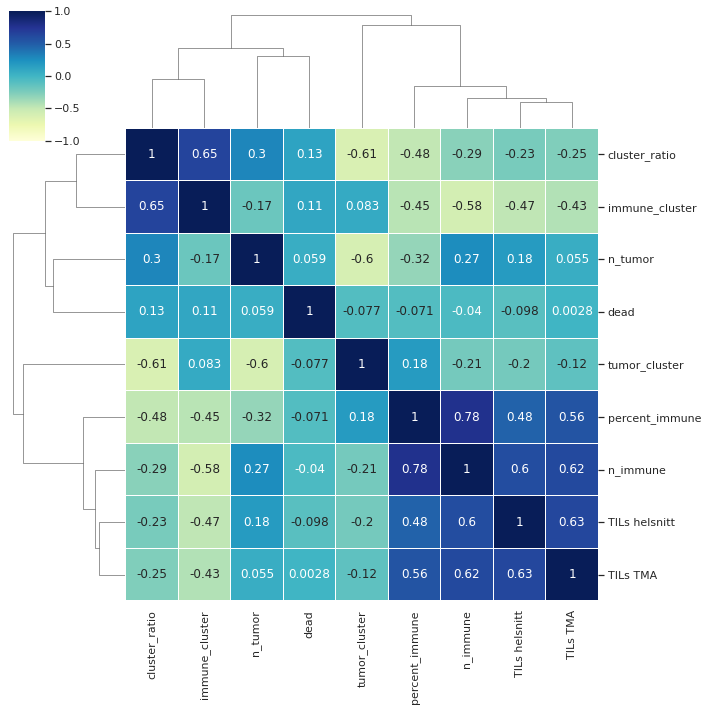

<Figure size 864x720 with 0 Axes>

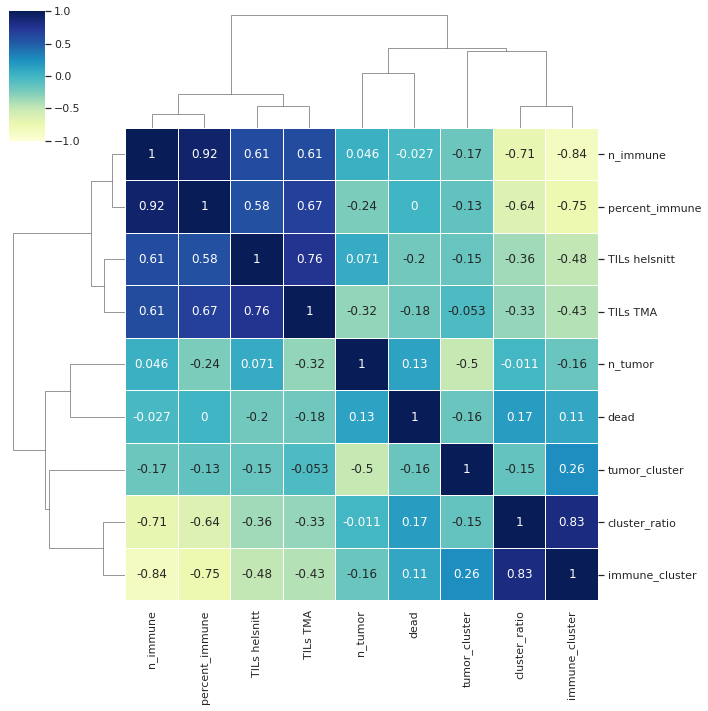

In [253]:
features = [
    'n_immune',
    'n_tumor',
    'percent_immune',
    'cluster_ratio',
    'immune_cluster',
    'tumor_cluster',
    'TILs helsnitt',
    'TILs TMA',
    'dead',
]
df_treated = df_all[df_all["treated"] == 1]
df_untreated = df_all[df_all["treated"] == 0]

corrmat = df_treated[features].corr(method='spearman')
plt.figure(figsize=(12,10))
sns.clustermap(corrmat, vmin=-1, cmap="YlGnBu", linewidth=0.1, annot=True)

corrmat = df_untreated[features].corr(method='spearman')
plt.figure(figsize=(12,10))
sns.clustermap(corrmat, vmin=-1, cmap="YlGnBu", linewidth=0.1, annot=True)

Ttest_indResult(statistic=-0.5695873184985984, pvalue=0.5764612798241862)

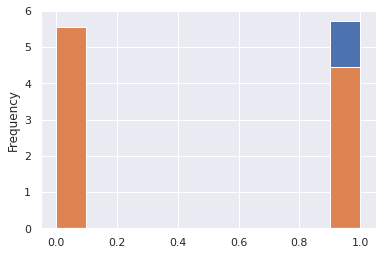

In [252]:
feature = "high_tils"
df_untreated.groupby("dead")[feature].plot.hist(density=True)
a = df_untreated[df_untreated["dead"] == 1][feature]
b = df_untreated[df_untreated["dead"] == 0][feature]
ttest_ind(a, b, equal_var = False)

<AxesSubplot:ylabel='Frequency'>

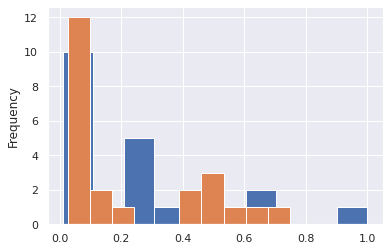

In [149]:
df_no_treat["TILs helsnitt"].plot.hist()
df_no_treat["TILs TMA"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

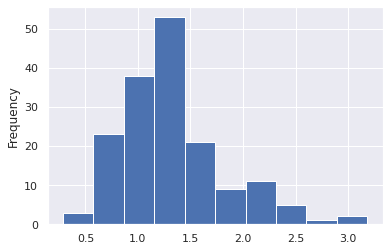

In [122]:
df_all["cluster_ratio"].plot.hist()

In [226]:
import statsmodels.api as sm
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import seaborn as sn

features = [
    'n_tumor',
    'n_immune',
    'percent_immune',
    'immune_cluster',
    'tumor_cluster',
    'cluster_ratio',
    'Age at diagnosis',
]
classes = ["dead"]
df = df_untreated[features + classes].dropna()
X = df[features]
y = df[classes]
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

def _results_to_pandas(summary):
    return pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

cm_list = []
results = []
outer_results = []
for train_val_idx, test_idx in cv_outer.split(X):
    X_train_val, X_test = X.iloc[train_val_idx, :], X.iloc[test_idx, :]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
        
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    for train_idx, val_idx in cv_inner.split(X_train_val):
        x_train, x_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
        #model = sm.Logit(y_train, x_train).fit(disp=False)
        model = RandomForestClassifier()
        model.fit(x_train.values, y_train.values.ravel())
        y_pred = np.around(model.predict(x_val))
        cm_list.append(confusion_matrix(y_val, y_pred))
        #results.append(_results_to_pandas(model.summary()))
            
            

df_cm = pd.DataFrame(np.sum(cm_list, axis=0))
plt.figure(figsize=(5,5))
sn.heatmap(df_cm, annot=True)
sum(results) / len(results)

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.